In [1]:
import os, sys
script_dir = os.getcwd()
module_path = script_dir
for _ in range(1):
    module_path = os.path.abspath(os.path.join(module_path, '../'))
    if module_path not in sys.path:
        sys.path.insert(0,module_path)


from src import decode_moddeling, prefill_moddeling, get_best_parallization_strategy
from src.LLM_inference.utils import get_inference_system

import pandas as pd
from plotnine import *
import plotnine as p9
import numpy as np
from variables import *

/Users/abambhaniya3/.local/lib/python3.12/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# This will reload the imported modules (e.g. get_decode_model_characterstics) every time you execute the jupyter cells, so that you don't need to restart the notebook after updating the source codes.
%load_ext autoreload
%autoreload 2   

### Variables

## Number of Nodes BW

In [3]:
system_list = [{'Flops': 9600, 'Memory_size': 40, 'Memory_BW': 4000, 'ICN': 300 , 'real_values':True},
               {'Flops': 6400, 'Memory_size': 40, 'Memory_BW': 4000, 'ICN': 300 , 'real_values':True},
               {'Flops': 3200, 'Memory_size': 40, 'Memory_BW': 4000, 'ICN': 300 , 'real_values':True},
               {'Flops': 1600, 'Memory_size': 40, 'Memory_BW': 4000, 'ICN': 300 , 'real_values':True},
               {'Flops': 800, 'Memory_size': 40, 'Memory_BW': 4000, 'ICN': 300 , 'real_values':True},
               ]
System_names_in_plot = [ '12x', '8x', '4x', '2x', 
                         '1x']

Model_list = [ 'mixtral_7x8',  'gpt-3']
Model_names_in_plot = ['Mixtral-8x7B', 'GPT3-175B'] ## Only to be used for plot

In [4]:
data = []
batch_size_list = [1]
bits = 'fp8'
for usecase in Decode_requirements.keys():
    b,bb,in_tokens, out_tokens, _ = Decode_requirements[usecase]
    for model in Model_list:
        model_df, summary_table = decode_moddeling(model = model, batch_size = max(batch_size_list), Bb = bb ,
                                input_tokens = in_tokens, output_tokens = out_tokens, model_profilling=True,
                                tensor_parallel = 1, pipeline_parallel = 1, bits=bits)
        Total_memory_required = (summary_table.loc[0,'Model Weights (MB)'] + summary_table.loc[0,'KV Cache (MB)'])   ## MBs
        system_name = system_list[-1]
        system = get_inference_system(system_name = system_name, bits = bits)
        Node_memory_size = system.get_off_chip_mem_size()       ## In MBs
        Num_nodes = Total_memory_required / Node_memory_size
        if Num_nodes <= 1:
            Num_nodes = 1
        else:
            Num_nodes = int(np.power(2,np.ceil(np.log2(Num_nodes))))
        Memory_amount_required = Total_memory_required
        ##### RE verifying the memory sizes
        while 1:
            try:    ## Check if model fits
                Parallelism_row = get_best_parallization_strategy(stage='decode', model=model, total_nodes=Num_nodes, batch_size = max(batch_size_list), beam_size = bb,
                            input_tokens = in_tokens, output_tokens = out_tokens,
                            system_name = system_name, bits=bits, debug=False)
                break
            except: ## If model doesn't fit, have 2x number of cores.
                Num_nodes *= 2
        # print(model, system_name, Num_nodes, Parallelism_row)
        model_df, summary_table = decode_moddeling(model = model, batch_size = max(batch_size_list)/Parallelism_row['PP'].values[0], Bb = bb ,
                            input_tokens = in_tokens, output_tokens = out_tokens, model_profilling=True,
                            tensor_parallel = Parallelism_row['TP'].values[0], pipeline_parallel = Parallelism_row['PP'].values[0], bits=bits)
        Memory_amount_required = (summary_table.loc[0,'Model Weights (MB)'] + summary_table.loc[0,'KV Cache (MB)'])   ## MBs

            
        ### Verified the num nodes
        TP = Parallelism_row['TP'].values[0]
        PP = Parallelism_row['PP'].values[0] 
        Node_total_memory = TP * PP * Node_memory_size
        for system_name in system_list:
            for b in batch_size_list:
                data.append([system_name, usecase, model, b, Total_memory_required, TP, PP, Node_total_memory]+list(summary_table.values[0]))
df = pd.DataFrame(data, columns=(['System', 'Usecase', 'Model', 'Batch', 'Req Memory Size(MB)', 'TP', 'PP', 'Cores Total Memory (MB)']+list(summary_table.columns)) )


/Users/abambhaniya3/Dropbox (GaTech)/Projects/GPT inference/Micro/GenZ/src/LLM_inference/llm_decode.py:113: UserWarning: All params would not fit on chip. System Memory Cap:40.0 GB , Weights : 43.25 GB, KV Cache:0.29296875 
/Users/abambhaniya3/Dropbox (GaTech)/Projects/GPT inference/Micro/GenZ/src/LLM_inference/llm_decode.py:113: UserWarning: All params would not fit on chip. System Memory Cap:40.0 GB , Weights : 162.0 GB, KV Cache:3.955078125 
/Users/abambhaniya3/Dropbox (GaTech)/Projects/GPT inference/Micro/GenZ/src/LLM_inference/llm_decode.py:113: UserWarning: All params would not fit on chip. System Memory Cap:40.0 GB , Weights : 43.25 GB, KV Cache:0.48828125 
/Users/abambhaniya3/Dropbox (GaTech)/Projects/GPT inference/Micro/GenZ/src/LLM_inference/llm_decode.py:113: UserWarning: All params would not fit on chip. System Memory Cap:40.0 GB , Weights : 162.0 GB, KV Cache:10.986328125 
/Users/abambhaniya3/Dropbox (GaTech)/Projects/GPT inference/Micro/GenZ/src/LLM_inference/llm_decode.p

In [5]:
df["Latency (ms)"] = ""
df["QPS (Query/s)"] = ""
df["Prefill Attn Time (ms)"] = ""
df["Prefill GEMM Time (ms)"] = ""
df["Prefill Communication Time (ms)"] = ""
df["Decode Attn Time (ms)"] = ""
df["Decode GEMM Time (ms)"] = ""
df["Decode Communication Time (ms)"] = ""
for df_idx in range(len(df)):
    df_row = df.loc[df_idx]
    # print(df_idx, df_row)
    b,bb,in_tokens, out_tokens, _ = Decode_requirements[df_row['Usecase']]
    prefill_outputs = prefill_moddeling(model = df_row['Model'], batch_size = df_row['Batch'],
                                input_tokens = in_tokens, output_tokens = out_tokens, FLAT = True,
                                system_name = df_row['System'], bits=bits, 
                                tensor_parallel = df_row['TP'], pipeline_parallel = df_row['PP'], debug=False, time_breakdown=True) 
    decode_outputs = decode_moddeling(model = df_row['Model'], batch_size = df_row['Batch'], Bb = bb ,
                                input_tokens = in_tokens, output_tokens = out_tokens, FLAT = True,
                                system_name = df_row['System'], bits=bits,
                                tensor_parallel = df_row['TP'], pipeline_parallel = df_row['PP'], debug=False, time_breakdown=True) 
    
    total_latency = prefill_outputs['Latency'] + out_tokens*decode_outputs['Latency']
    df.loc[df_idx,"Latency (s)"] = total_latency / 1000
    df.loc[df_idx,"QPS (Query/s)"] = df_row['Batch']/df.loc[df_idx,"Latency (s)"]
    
    df.loc[df_idx,"Prefill GEMM Time (ms)"] = prefill_outputs['Runtime_breakdown'][0] 
    df.loc[df_idx,"Prefill Attn Time (ms)"] = prefill_outputs['Runtime_breakdown'][1]
    df.loc[df_idx,"Prefill Communication Time (ms)"] = prefill_outputs['Runtime_breakdown'][2]

    df.loc[df_idx,"Decode GEMM Time (ms)"] = decode_outputs['Runtime_breakdown'][0]
    df.loc[df_idx,"Decode Attn Time (ms)"] = decode_outputs['Runtime_breakdown'][1]
    df.loc[df_idx,"Decode Communication Time (ms)"] = decode_outputs['Runtime_breakdown'][2]
        # data.append([total_batch_size, total_nodes//i, i , latency, thrpt, breakdown])

In [10]:
df

,System,Usecase,Model,Batch,Req Memory Size(MB),TP,PP,Cores Total Memory (MB),MACs (MFLOP),Total Data (MB),...,Latency (ms),QPS (Query/s),Prefill Attn Time (ms),Prefill GEMM Time (ms),Prefill Communication Time (ms),Decode Attn Time (ms),Decode GEMM Time (ms),Decode Communication Time (ms),Latency (s),QPS (Query/s))
0,"{'Flops': 9600, 'Memory_size': 40, 'Memory_BW'...",QA,mixtral_7x8,1,44588.0,2,1,81920.0,51724.156928,22308.062500,...,,2.35773,0.091129,5.848755,1.389802,0.03712,1.470795,0.579255,0.424137,2.357730
1,"{'Flops': 6400, 'Memory_size': 40, 'Memory_BW'...",QA,mixtral_7x8,1,44588.0,2,1,81920.0,51724.156928,22308.062500,...,,2.35773,0.091129,5.848755,1.389802,0.03712,1.470795,0.579255,0.424137,2.357730
2,"{'Flops': 3200, 'Memory_size': 40, 'Memory_BW'...",QA,mixtral_7x8,1,44588.0,2,1,81920.0,51724.156928,22308.062500,...,,2.35773,0.091129,5.848755,1.389802,0.03712,1.470795,0.579255,0.424137,2.357730
3,"{'Flops': 1600, 'Memory_size': 40, 'Memory_BW'...",QA,mixtral_7x8,1,44588.0,2,1,81920.0,51724.156928,22308.062500,...,,2.356819,0.091129,6.012753,1.389802,0.03712,1.470795,0.579255,0.424301,2.356819
4,"{'Flops': 800, 'Memory_size': 40, 'Memory_BW':...",QA,mixtral_7x8,1,44588.0,2,1,81920.0,51724.156928,22308.062500,...,,2.346063,0.16384,7.885292,1.389802,0.03712,1.470795,0.579255,0.426246,2.346063
5,"{'Flops': 9600, 'Memory_size': 40, 'Memory_BW'...",QA,gpt-3,1,169938.0,8,1,327680.0,175007.858688,21272.361328,...,,0.428,0.256538,6.57312,19.153383,0.124154,5.068542,6.38727,2.336446,0.428000
6,"{'Flops': 6400, 'Memory_size': 40, 'Memory_BW'...",QA,gpt-3,1,169938.0,8,1,327680.0,175007.858688,21272.361328,...,,0.428,0.256538,6.57312,19.153383,0.124154,5.068542,6.38727,2.336446,0.428000
7,"{'Flops': 3200, 'Memory_size': 40, 'Memory_BW'...",QA,gpt-3,1,169938.0,8,1,327680.0,175007.858688,21272.361328,...,,0.42793,0.256538,6.959407,19.153383,0.124154,5.068542,6.38727,2.336832,0.427930
8,"{'Flops': 1600, 'Memory_size': 40, 'Memory_BW'...",QA,gpt-3,1,169938.0,8,1,327680.0,175007.858688,21272.361328,...,,0.426719,0.256538,13.589545,19.153383,0.124154,5.068542,6.38727,2.343463,0.426719
9,"{'Flops': 800, 'Memory_size': 40, 'Memory_BW':...",QA,gpt-3,1,169938.0,8,1,327680.0,175007.858688,21272.361328,...,,0.424239,0.36864,27.17909,19.153383,0.124154,5.068542,6.38727,2.357164,0.424239


In [6]:
df['Latency (s)'] = df['Latency (s)'].astype(float)
df['QPS (Query/s))'] = df['QPS (Query/s)'].astype(float)
df.replace(Model_list, Model_names_in_plot)
plot_df = df.replace(Model_list, Model_names_in_plot)
plot_df = plot_df.replace(system_list, System_names_in_plot)
plot_df['Model'] = pd.Categorical(plot_df['Model'], categories=Model_names_in_plot)
plot_df['Usecase'] = pd.Categorical(plot_df['Usecase'], categories=Decode_requirements.keys())
plot_df['System'] = pd.Categorical(plot_df['System'], categories=System_names_in_plot)
plot_df['Real Systems'] = plot_df.apply(lambda row: False if "Sys_" in row['System'] else True , axis=1)
# plot_df['Num Cores'] = pd.Categorical(plot_df['Num Cores'], categories=np.sort(df['Num Cores'].unique()))
plot_df['Num Cores'] = plot_df['TP'] * plot_df['PP']

/var/folders/h1/r_4mhdb92_7cg5n015yr61wh0000gp/T/ipykernel_58032/407643048.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/var/folders/h1/r_4mhdb92_7cg5n015yr61wh0000gp/T/ipykernel_58032/407643048.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


In [11]:
plot_df

,System,Usecase,Model,Batch,Req Memory Size(MB),TP,PP,Cores Total Memory (MB),MACs (MFLOP),Total Data (MB),...,Prefill Attn Time (ms),Prefill GEMM Time (ms),Prefill Communication Time (ms),Decode Attn Time (ms),Decode GEMM Time (ms),Decode Communication Time (ms),Latency (s),QPS (Query/s)),Real Systems,Num Cores
0,12x,QA,Mixtral-8x7B,1,44588.0,2,1,81920.0,51724.156928,22308.062500,...,0.091129,5.848755,1.389802,0.037120,1.470795,0.579255,0.424137,2.357730,True,2
1,8x,QA,Mixtral-8x7B,1,44588.0,2,1,81920.0,51724.156928,22308.062500,...,0.091129,5.848755,1.389802,0.037120,1.470795,0.579255,0.424137,2.357730,True,2
2,4x,QA,Mixtral-8x7B,1,44588.0,2,1,81920.0,51724.156928,22308.062500,...,0.091129,5.848755,1.389802,0.037120,1.470795,0.579255,0.424137,2.357730,True,2
3,2x,QA,Mixtral-8x7B,1,44588.0,2,1,81920.0,51724.156928,22308.062500,...,0.091129,6.012753,1.389802,0.037120,1.470795,0.579255,0.424301,2.356819,True,2
4,1x,QA,Mixtral-8x7B,1,44588.0,2,1,81920.0,51724.156928,22308.062500,...,0.163840,7.885292,1.389802,0.037120,1.470795,0.579255,0.426246,2.346063,True,2
5,12x,QA,GPT3-175B,1,169938.0,8,1,327680.0,175007.858688,21272.361328,...,0.256538,6.573120,19.153383,0.124154,5.068542,6.387270,2.336446,0.428000,True,8
6,8x,QA,GPT3-175B,1,169938.0,8,1,327680.0,175007.858688,21272.361328,...,0.256538,6.573120,19.153383,0.124154,5.068542,6.387270,2.336446,0.428000,True,8
7,4x,QA,GPT3-175B,1,169938.0,8,1,327680.0,175007.858688,21272.361328,...,0.256538,6.959407,19.153383,0.124154,5.068542,6.387270,2.336832,0.427930,True,8
8,2x,QA,GPT3-175B,1,169938.0,8,1,327680.0,175007.858688,21272.361328,...,0.256538,13.589545,19.153383,0.124154,5.068542,6.387270,2.343463,0.426719,True,8
9,1x,QA,GPT3-175B,1,169938.0,8,1,327680.0,175007.858688,21272.361328,...,0.368640,27.179090,19.153383,0.124154,5.068542,6.387270,2.357164,0.424239,True,8


In [17]:
breadkdown_df = plot_df[(plot_df['Usecase'] == 'QA + RAG') & (plot_df['Batch'] == 1)]

/var/folders/h1/r_4mhdb92_7cg5n015yr61wh0000gp/T/ipykernel_58032/2696875731.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/var/folders/h1/r_4mhdb92_7cg5n015yr61wh0000gp/T/ipykernel_58032/2696875731.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/var/folders/h1/r_4mhdb92_7cg5n015yr61wh0000gp/T/ipykernel_58032/2696875731.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


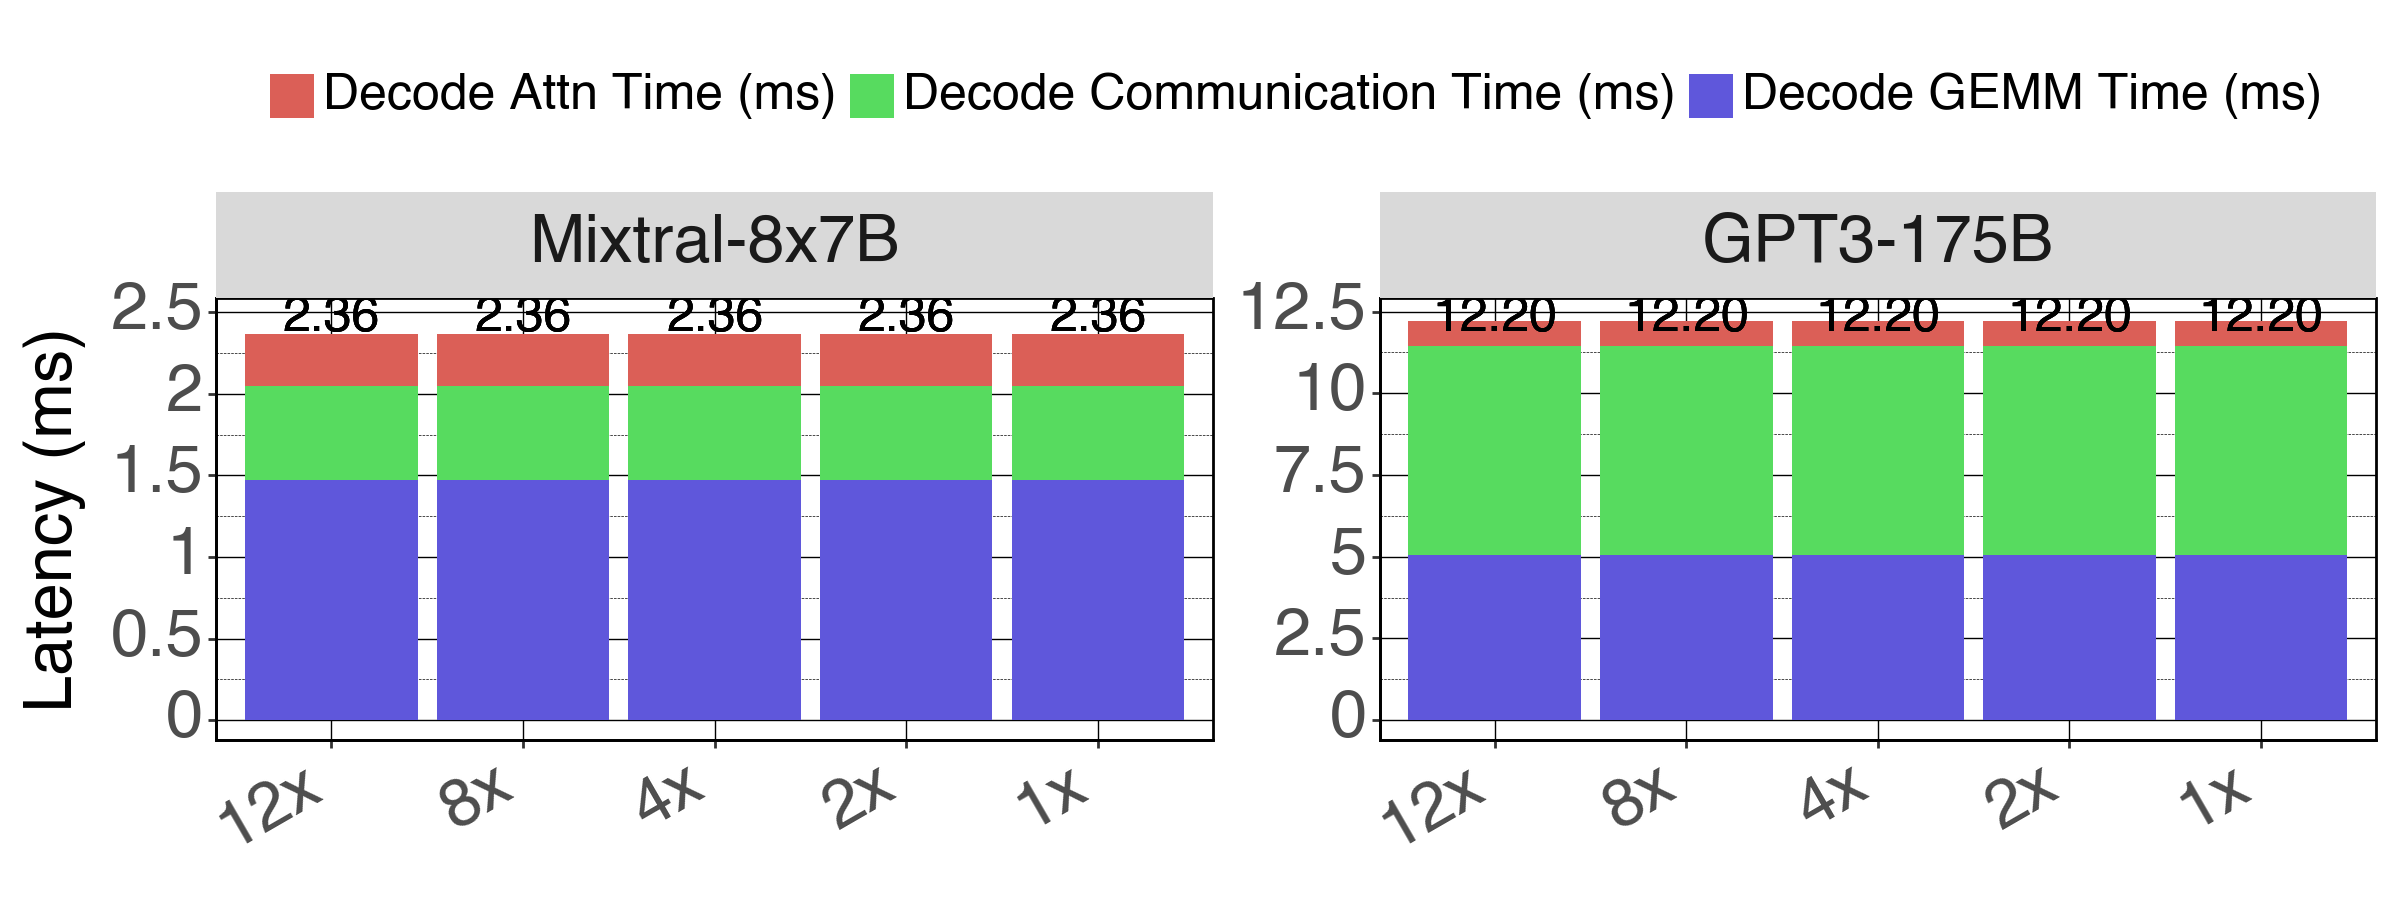

In [18]:
df_long = pd.melt(breadkdown_df, id_vars=['System', 'Usecase', 'Model', 'Batch', 'Req Memory Size(MB)', 'TP',
       'PP', 'Cores Total Memory (MB)', 'MACs (MFLOP)', 'Total Data (MB)',
       'Model Weights (MB)', 'Unused Weights (MB)', 'KV Cache (MB)',
       'AR data (MB)', 'Pipe data  (MB)', 'Latency (ms)', 'QPS (Query/s)',
       'Prefill Attn Time (ms)', 'Prefill GEMM Time (ms)',
       'Prefill Communication Time (ms)', 
       'Latency (s)', 'QPS (Query/s))', 'Real Systems', 'Num Cores'], var_name="Time")
df_long['value'] = df_long['value'].astype(float)
df_long['total'] = df_long.groupby(['System', 'Model'])['value'].transform('sum')

df_long = df_long.replace(Model_list, Model_names_in_plot)
# df_long['TFLOPS'] = df_long['Num Cores'] * df_long['System']
# df_long['TFLOPS'] = df_long.apply(lambda row: row['Num Cores'] * eval(row['System'].split('_')[1]) , axis=1)
# df_long['TFLOPS'] = pd.Categorical(df_long['TFLOPS'], categories=df_long['TFLOPS'].unique().sort() ).astype(str)
# for _usecase_ in df_long['Usecase'].unique():
# Assuming your data is in the df_long dataframe
df_ratios = (df_long.groupby(['System', 'Model'])['total']
                    .max()
                    .reset_index()
                    .rename(columns={'total': 'max_value'}))

df_ratios['ratio'] =  df_ratios.groupby('Model')['max_value'].transform('max') /df_ratios['max_value'] 
plot = (
    ggplot(df_long, aes(x='System',y='value',fill ='Time'))
    + geom_bar(stat='identity',position='stack') 
    + p9.labs(y='Latency (ms)', x='TFLOPS')
    + plot_theme
    + p9.theme(axis_text_x=p9.element_text(rotation=30, hjust=1), axis_title_x=p9.element_blank())
    + p9.theme(figure_size=(12, 5.5),legend_text=p9.element_text(size=18),legend_title=p9.element_blank())
    + theme(figure_size=(12,4.55), legend_position='top')
    # + p9.geom_segment(pd.DataFrame({'x': [0.15], 'y': [260], 'xend': [0.4], 'yend': [470]}), aes(x='x', y='y', xend='xend', yend='yend'), arrow=p9.arrow(), size = 2, color='red')
    # + p9.geom_text(p9.aes(x = 0.35, y = 325),label = f"As # Batch inc.: \n PP gives higher \n thrpt than TP  ", size=25)
    + p9.facet_wrap("~ Model ", scales = 'free' , ncol=5)
    + geom_text(aes(x='System', y='total+0.1', label='total'), format_string='{:.2f}', stat='summary', size=18, color='black') 

    # + p9.faceh_wrap("Usecase", scales = 'free' , )
)
print(plot)

In [19]:
df_ratios

,System,Model,max_value,ratio
0,12x,Mixtral-8x7B,2.363735,1.0
1,12x,GPT3-175B,12.199020,1.0
2,8x,Mixtral-8x7B,2.363735,1.0
3,8x,GPT3-175B,12.199020,1.0
4,4x,Mixtral-8x7B,2.363735,1.0
5,4x,GPT3-175B,12.199020,1.0
6,2x,Mixtral-8x7B,2.363735,1.0
7,2x,GPT3-175B,12.199020,1.0
8,1x,Mixtral-8x7B,2.363735,1.0
9,1x,GPT3-175B,12.199020,1.0


/var/folders/h1/r_4mhdb92_7cg5n015yr61wh0000gp/T/ipykernel_58032/1545752254.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/var/folders/h1/r_4mhdb92_7cg5n015yr61wh0000gp/T/ipykernel_58032/1545752254.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/var/folders/h1/r_4mhdb92_7cg5n015yr61wh0000gp/T/ipykernel_58032/1545752254.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


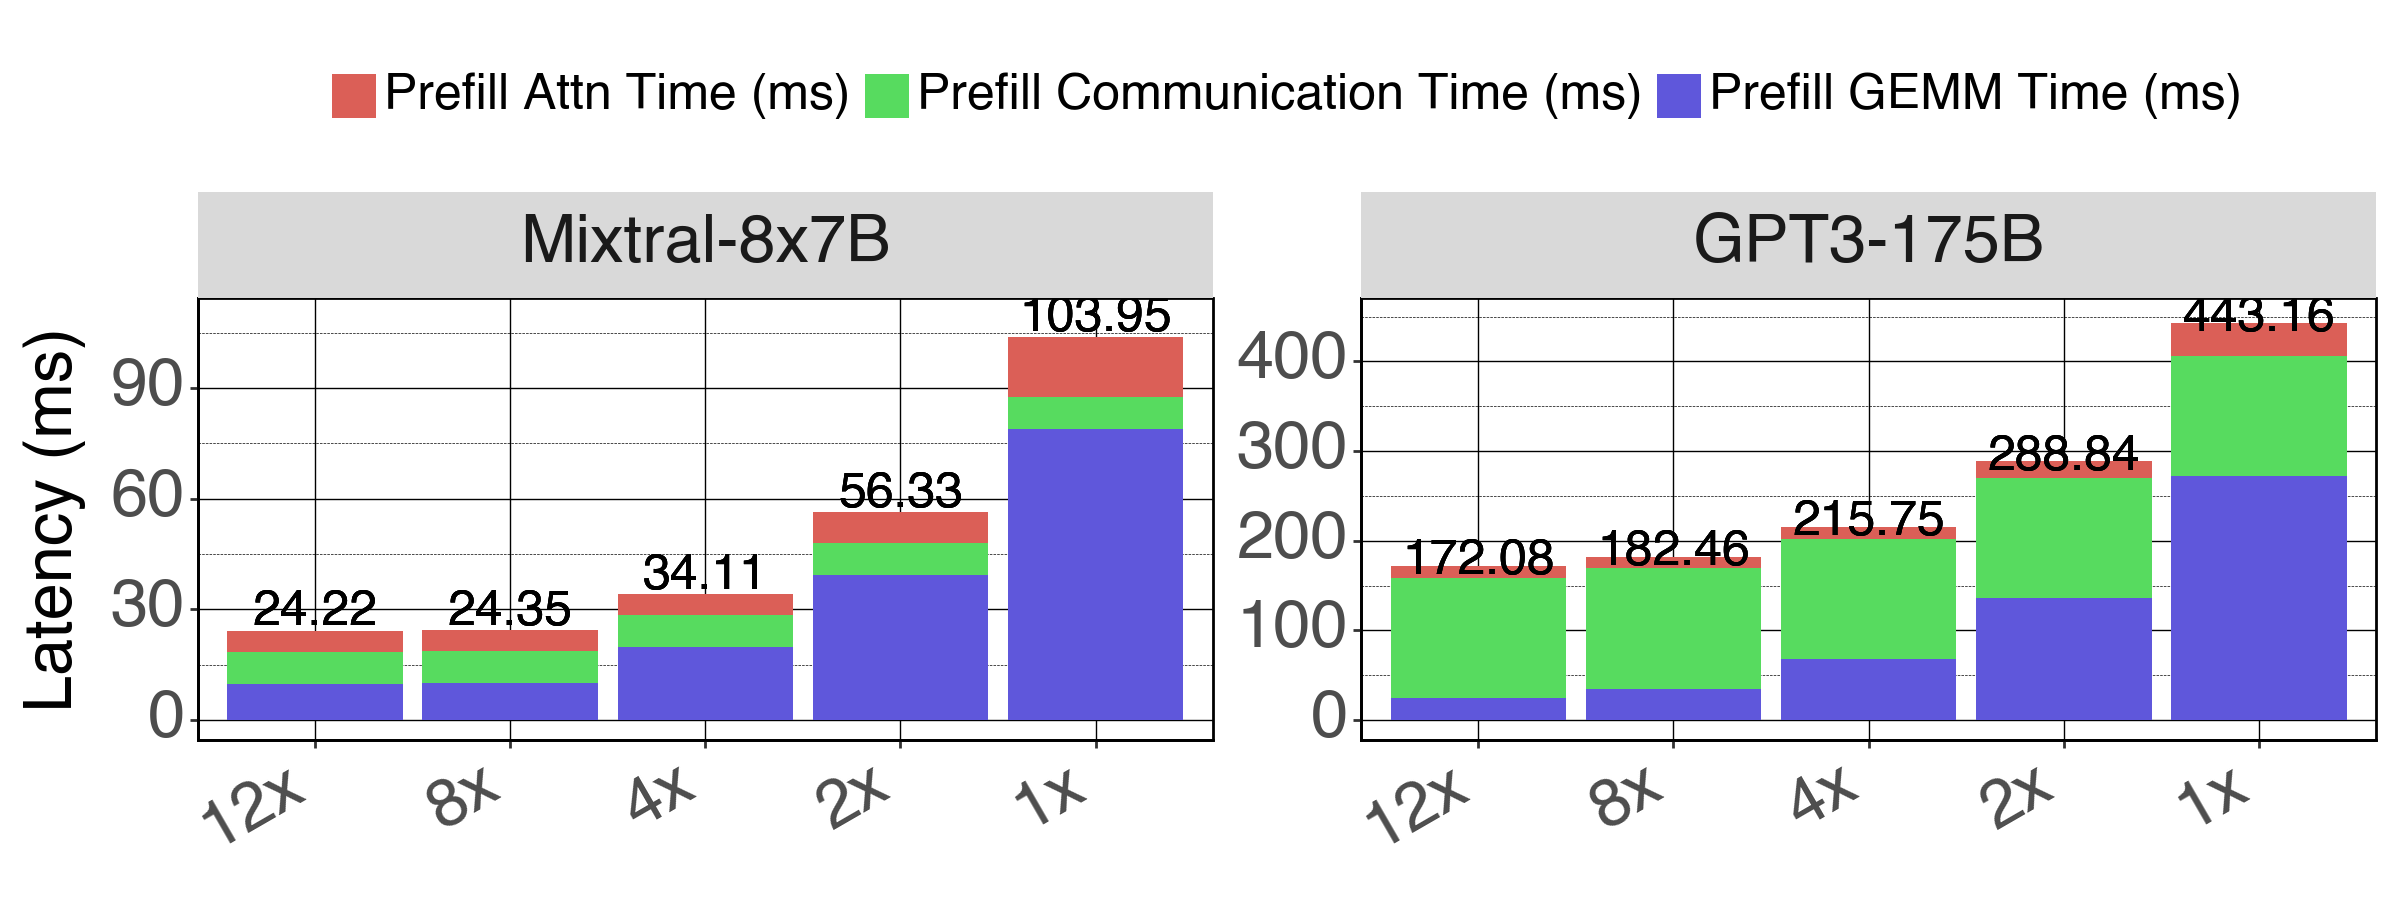

In [20]:
df_long = pd.melt(breadkdown_df, id_vars=['System', 'Usecase', 'Model', 'Batch', 'Req Memory Size(MB)', 'TP',
       'PP', 'Cores Total Memory (MB)', 'MACs (MFLOP)', 'Total Data (MB)',
       'Model Weights (MB)', 'Unused Weights (MB)', 'KV Cache (MB)',
       'AR data (MB)', 'Pipe data  (MB)', 'Latency (ms)', 'QPS (Query/s)',
       'Decode Attn Time (ms)', 'Decode GEMM Time (ms)',
       'Decode Communication Time (ms)', 
       'Latency (s)', 'QPS (Query/s))', 'Real Systems', 'Num Cores'], var_name="Time")
df_long['value'] = df_long['value'].astype(float)
df_long['total'] = df_long.groupby(['System', 'Model'])['value'].transform('sum')
df_long = df_long.replace(Model_list, Model_names_in_plot)
# Assuming your data is in the df_long dataframe
df_ratios = (df_long.groupby(['System', 'Model'])['total']
                    .max()
                    .reset_index()
                    .rename(columns={'total': 'max_value'}))

df_ratios['ratio'] =  df_ratios.groupby('Model')['max_value'].transform('max') /df_ratios['max_value'] 
# df_ratios['Time reduction(%)'] = 1 - df_ratios['ratio'] 
# for _usecase_ in df_long['Usecase'].unique():
plot = (
    ggplot(df_long, aes(x='System',y='value',fill ='Time'))
    + geom_bar(stat='identity',position='stack') 
    + p9.labs(y='Latency (ms)', x='TFLOPS')

    + plot_theme
    + p9.theme(axis_text_x=p9.element_text(rotation=30, hjust=1), axis_title_x=p9.element_blank())
    + p9.theme(figure_size=(12, 5.5),legend_text=p9.element_text(size=18),legend_title=p9.element_blank())
    + theme(figure_size=(12,4.55), legend_position='top')
    # + p9.geom_segment(pd.DataFrame({'x': [0.15], 'y': [260], 'xend': [0.4], 'yend': [470]}), aes(x='x', y='y', xend='xend', yend='yend'), arrow=p9.arrow(), size = 2, color='red')
    # + p9.geom_text(p9.aes(x = 0.35, y = 325),label = f"As # Batch inc.: \n PP gives higher \n thrpt than TP  ", size=25)
    + p9.facet_wrap("~ Model ", scales = 'free' , ncol=5)
    + geom_text(aes(x='System', y='total+5', label='total'), format_string='{:.2f}', stat='summary', size=18, color='black') 

    # + p9.faceh_wrap("Usecase", scales = 'free' , )
)
print(plot)


In [21]:
df_ratios

,System,Model,max_value,ratio
0,12x,Mixtral-8x7B,24.224980,4.291064
1,12x,GPT3-175B,172.077633,2.575377
2,8x,Mixtral-8x7B,24.351129,4.268834
3,8x,GPT3-175B,182.458535,2.428852
4,4x,Mixtral-8x7B,34.106910,3.047797
5,4x,GPT3-175B,215.751773,2.054049
6,2x,Mixtral-8x7B,56.332478,1.845311
7,2x,GPT3-175B,288.837278,1.534306
8,1x,Mixtral-8x7B,103.950936,1.000000
9,1x,GPT3-175B,443.164727,1.000000
